In [62]:
import numpy as np
from matplotlib import pyplot as plt

import astropy.units as u

import warnings
warnings.filterwarnings("ignore")

import logging
from gammapy.maps import MapAxis, WcsGeom

from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from gammapy.data import DataStore
from gammapy.modeling.models import PowerLawSpectralModel
from gammapy.datasets import Datasets, SpectrumDataset, FluxPointsDataset
from gammapy.estimators import FluxPointsEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)

from astroquery.simbad import Simbad
from astropy.coordinates import Angle, SkyCoord
from gammapy.maps import MapAxis, RegionGeom
from gammapy.visualization import plot_spectrum_datasets_off_regions

import seaborn as sns

sns.set(font="MathJax_Main",style='ticks',context='talk',palette='pastel')

log = logging.getLogger(__name__)

In [63]:
target_position = SkyCoord(83.6333,22.0145,unit='deg')
data_store = DataStore.from_dir('/raid/romulus/swong/mydl3/crabtest_2025/')

observations = data_store.get_observations(required_irf=['aeff', 'edisp'])

In [76]:
energy_axis = MapAxis.from_energy_bounds("0.01 TeV", "100 TeV", nbin=100)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "100 TeV", nbin=200, name="energy_true"
)

In [77]:
exclusion_geom = WcsGeom.create(
    skydir=(target_position.ra.value, target_position.dec.value),
    binsz=0.01,
    width=(4, 4),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)
simbad = Simbad()
simbad.reset_votable_fields()
simbad.add_votable_fields('ra', 'dec', "flux(B)", "flux(V)", "jp11")
simbad.remove_votable_fields('coordinates')

srcs_tab = simbad.query_region(target_position, radius=1.5*u.deg)
srcs_tab = srcs_tab[srcs_tab["FLUX_B"]<8]
srcs_tab = srcs_tab[srcs_tab["FLUX_V"]!=np.ma.masked]

# Make the exclusion mask
exclusion_geom_image = exclusion_geom.to_image().to_cube([energy_axis.squash()])

regions = CircleSkyRegion(center=target_position, radius=0.35 * u.deg)
all_ex = [regions]
stars = []

for star in srcs_tab:
    pos = SkyCoord(star["RA"], star["DEC"], frame="fk5", unit=(u.hourangle, u.deg))
    star = CircleSkyRegion(center=pos, radius=0.3 * u.deg)
    stars.append(star)
    all_ex.append(star)

exclusion_mask = ~exclusion_geom_image.region_mask(all_ex)

In [78]:
on_region_radius = Angle("0.0894427191 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

In [83]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_masker = SafeMaskMaker(methods=["offset-max"], aeff_percent=10,offset_max=1.75*u.deg)

In [84]:
datasets = Datasets()
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)
for obs in observations:
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs.obs_id)), obs)

    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

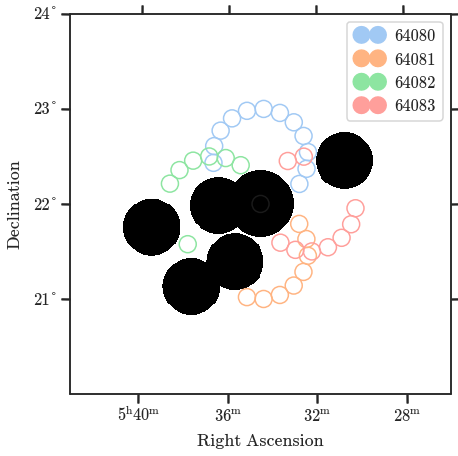

In [85]:
plt.figure(figsize=(7,7))
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)
plt.show()

In [87]:
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,129,124.0,20.859880834340355,5.0,14.53846193841223,14.53846193841223,nan,696243.875,135168416.0,1013.5001294841763,1201.9999999999993,0.1272816808278603,0.004933398481700011,0.12234828234616027,100,100,wstat,503.59145469530085,60,100.0,1200.0,0.0833333358168602
stacked,305,296.5,32.866339753549994,8.5,35.23552033051467,35.23552033051467,nan,1434736.75,269125568.0,2027.6745230741103,2403.9999999999986,0.15041861823937924,0.004191994278802373,0.14622662396057687,100,100,wstat,1156.317557383705,88,200.0,2070.58837890625,0.09659090638160706
stacked,456,442.21429443359375,39.079225381648996,13.785714149475098,58.08685754103158,58.08685754103158,nan,2115223.0,402405504.0,3033.1929362464048,3606.0000000000027,0.1503366286235332,0.004544951290350493,0.14579168016289681,100,100,wstat,1645.7958518345085,125,300.0,2720.207275390625,0.11028571426868439
stacked,617,598.3253784179688,45.438694175229536,18.674602508544922,78.60833395628717,78.60833395628717,nan,2795034.75,541121728.0,4047.605049869505,4807.999999999997,0.15243582128149882,0.004613741281192194,0.14782207528801725,100,100,wstat,2201.7487190413167,169,400.0,3619.8896484375,0.11050060391426086


In [93]:
info_table = datasets.info_table(cumulative=True)

print(f"ON: {info_table['counts'][-1]}\nOFF: {info_table['counts_off'][-1]}\nSignificance: {info_table['sqrt_ts'][-1]:.2f} sigma\nAlpha:{info_table['alpha'][-1]:.2f}")

ON: 617
OFF: 169
Significance: 45.44 sigma
Alpha:0.11
